# **IMPORTATIONS**

In [171]:
import pickle
with open('df_complete.pickle', 'rb') as f:
    df = pickle.load(f)

In [172]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# **PRE-PROCESSING**

On normalise les données et sépare les données d'entrainement et de tests : 

In [173]:
X, y = df.drop(columns=['num']).values, df['num'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **MODÈLE**

Regardons dans un premier temps les paramètre qu'utilise le KNeighborsClassifier par défault : 

In [174]:
classifier = RandomForestClassifier()
print('Paramètres utilisés :\n')
pprint(classifier.get_params())

Paramètres utilisés :

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


On joue sur la plupart de ces paramètres pour déterminer quels sont les meilleurs paramètres (en utilisant GridSearchCV) : 

In [175]:
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [50]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

rfc = RandomForestClassifier(random_state=8)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    6.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_...
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=8,
                                              verbose=0, warm_start=False),
  

In [176]:
print("Les meilleurs paramètres (d'après la GridSearch) sont :")
print(grid_search.best_params_)
print("")
print("La précision moyenne d'un modèle avec ces hyperparamètres est:")
print(grid_search.best_score_)

Les meilleurs paramètres (d'après la GridSearch) sont :
{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 50}

La précision moyenne d'un modèle avec ces hyperparamètres est:
0.8120713305898491


On prend alors le modèle avec les meilleurs paramètres : 

In [177]:
best_rfc = grid_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [178]:
best_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [179]:
rfc_pred = best_rfc.predict(X_test)

**Regardons les résultats pour les données d'entrainement :**

* matrice de confusion : 

Text(0.5, 1, 'Confusion Matrix')

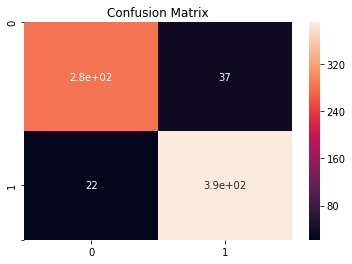

In [180]:
cm = confusion_matrix(y_train, best_rfc.predict(X_train))

df_cm = pd.DataFrame(cm, index=['1','0'], columns = ['0','1'])
fig = plt.figure()
plt.clf()

res = sns.heatmap(df_cm, annot=True)

plt.yticks( [1.5,0,2], va='center')
plt.title('Confusion Matrix')

* accuracy : 

In [181]:
print("Accuracy pour les données d'entrainement est : ")
print(accuracy_score(y_train, best_rfc.predict(X_train)))

Accuracy pour les données d'entrainement est : 
0.9196185286103542


* sensibilité : 

In [182]:
tpr = recall_score(y_train, best_rfc.predict(X_train))
print("La sensibilité pour les données d'entrainement est : ")
print(tpr)

La sensibilité pour les données d'entrainement est : 
0.9467312348668281


* précision : 

In [183]:
print("La précision pour les données d'entrainement est : ")
print(precision_score(y_train, best_rfc.predict(X_train)))

La précision pour les données d'entrainement est : 
0.9135514018691588


* F-Measure : 

In [184]:
print("F-Measure pour les données d'entrainement : ")
print(f1_score(y_train, best_rfc.predict(X_train)))

F-Measure pour les données d'entrainement : 
0.929845422116528


**Résultats pour les données tests :**

* matrice de confusion : 

Text(0.5, 1, 'Confusion Matrix')

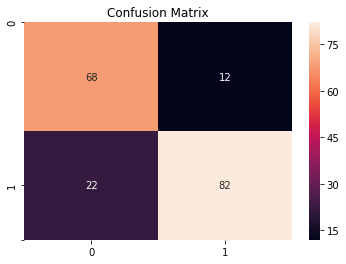

In [185]:
cm = confusion_matrix(rfc_pred,y_test)
df_cm = pd.DataFrame(cm, index=['1','0'], columns = ['0','1'])
fig = plt.figure()
plt.clf()

res = sns.heatmap(df_cm, annot=True)

plt.yticks( [1.5,0,2], va='center')
plt.title('Confusion Matrix')

* accuracy : 

In [186]:
print("Accuracy pour les données test : ")
print(accuracy_score(y_test, rfc_pred))

Accuracy pour les données test : 
0.8152173913043478


* sensibilté :

In [187]:
tpr = recall_score(y_test, rfc_pred)
print("La sensibilité pour les données tests est : ")
print(tpr)

La sensibilité pour les données tests est : 
0.8723404255319149


* précision :

In [188]:
print("La précision pour les données test est : ")
print(precision_score(y_test, rfc_pred))

La précision pour les données test est : 
0.7884615384615384


* F-Measure : 

In [189]:
print("F-Measure pour les données test : ")
print(f1_score(y_test, rfc_pred))

F-Measure pour les données test : 
0.8282828282828283


**Regroupons tout ça dans un dataframe pandas :** 

In [190]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(y_train, best_rfc.predict(X_train)),
     'Test Set Accuracy': accuracy_score(y_test, rfc_pred),
     'Training Set TPR' : recall_score(y_train, best_rfc.predict(X_train)),
     'Test Set TPR' : recall_score(y_test, rfc_pred),
     'Training Set PPV' : precision_score(y_train, best_rfc.predict(X_train)),
     'Test Set PPV' : precision_score(y_test, rfc_pred),
     'Training Set F-Measure' : f1_score(y_train, best_rfc.predict(X_train)),
     'Test Set F-Measure' : f1_score(y_test, rfc_pred)
}

df_models_rf = pd.DataFrame(d, index=[0])
df_models_rf

,Model,Training Set Accuracy,Test Set Accuracy,Training Set TPR,Test Set TPR,Training Set PPV,Test Set PPV,Training Set F-Measure,Test Set F-Measure
0,Random Forest,0.919619,0.815217,0.946731,0.87234,0.913551,0.788462,0.929845,0.828283


In [191]:
with open('df_models_rf.pickle', 'wb') as output:
    pickle.dump(df_models_rf, output)